# Identify Damaged Car Parts with Vertex AutoML Vision

## Overview
Vertex AI brings together the Google Cloud services for building ML under one, unified UI and API. In Vertex AI, you can now easily train and compare models using [AutoML](https://cloud.google.com/vertex-ai/docs/beginner/beginners-guide/) or custom code training and all your models are stored in one central model repository. These models can now be deployed to the same endpoints on Vertex AI.

AutoML Vision helps anyone with limited Machine Learning (ML) expertise train high quality image classification models. In this hands-on lab, you will learn how to produce a custom ML model that automatically recognizes damaged car parts.

Once you’ve produced your ML model, it’ll be immediately available for use. You can use the UI or the REST API to start generating predictions directly from the Google Cloud Console.

## Learning Objectives
In this lab, you learn how to:
- Upload a labeled dataset to Cloud Storage using a CSV file and connect it to Vertex AI as a Managed Dataset
- Inspect uploaded images to ensure there are no errors in your dataset
- Review your trained model and evaluate its accuracy


## Setup

In [1]:
import csv
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Upload training images to Cloud Storage
In this task you will upload the training images you want to use to Cloud Storage. This will make it easier to import the data into Vertex AI later.

To train a model to classify images of damaged car parts, you need to provide the machine with labeled training data. The model will use the data to develop an understanding of each image, differentiating between car parts and those with damages on them.

In this example, your model will learn to classify five different damaged car parts: **bumper**, **engine compartment**, **hood**, **lateral**, and **windshield**.


### Create a Cloud Storage bucket
To start, open a new Cloud Shell window and execute the following commands to set some environment variables:



In [2]:
PROJECT_ID = !(gcloud config get-value project)
PROJECT_ID = PROJECT_ID[0]
BUCKET = PROJECT_ID

Next, to create a Cloud Storage bucket, execute the following command:


In [ ]:
!gsutil mb -p {PROJECT_ID} \
    -c standard \
    -l us-central1 \
    gs://{BUCKET}

### Upload car images to your Storage Bucket
The training images are publicly available in a Cloud Storage bucket. Again, copy and paste the script template below into Cloud Shell to copy the images into your own bucket.

To copy images into your Cloud Storage bucket, execute the following command:



In [4]:
!gsutil -mq cp -r gs://asl-public/data/car_damage_lab_images* gs://{BUCKET}/car_damage_lab_images

Let's take a look at some samples.

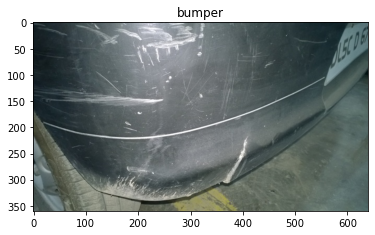

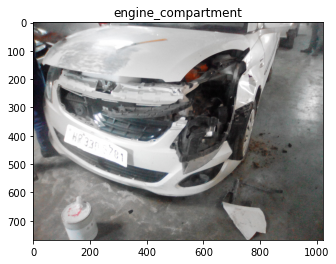

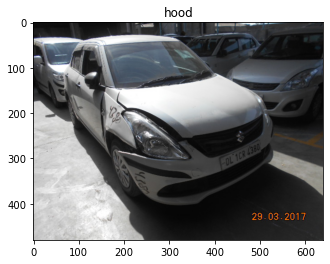

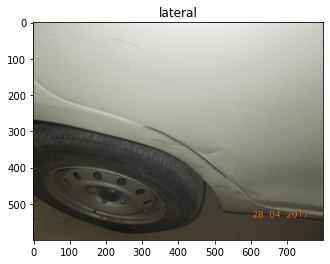

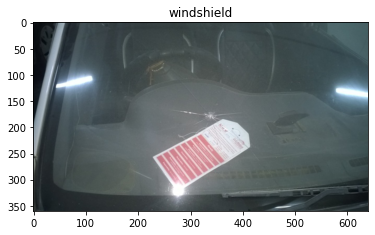

In [5]:
!mkdir ./car_damage_lab_images

LABELS = ["bumper", "engine_compartment", "hood", "lateral", "windshield"]
for l in LABELS:
    !gsutil -q cp gs://{BUCKET}/car_damage_lab_images/{l}/{l}1.jpg ./car_damage_lab_images
    img = mpimg.imread(f"car_damage_lab_images/{l}1.jpg")
    plt.imshow(img)
    plt.title(l)
    plt.show()

!rm -rf car_damage_lab_images

## Create a dataset
In this task, you create a new dataset and connect your dataset to your training images to allow Vertex AI to access them.

Let's create a CSV file where each row contains a URL to a training image and the associated label for that image.<br>
Also, optionally we can add a column which represent data split like `TRAIN` or `VALIDATION`.<br>


You can check the detail of CSV format in [the official document](https://cloud.google.com/vision/automl/object-detection/docs/csv-format).

In this case, labels for each image is represented as directory name. So we can create the csv in this command.

In [6]:
CSV_FILE = "car_damage_dataset.csv"

data_list = []

for l in LABELS:
    data = !gsutil ls gs://{BUCKET}/car_damage_lab_images/{l}
    for i, d in enumerate(data):
        assign = "TRAIN" if i % 5 > 0 else "VALIDATION"  # 80:20
        data_list.append([assign, d, l])

with open(CSV_FILE, "w") as f:
    write = csv.writer(f)
    write.writerows(data_list)

In [ ]:
!head ./car_damage_dataset.csv

Let's upload this CSV file to the GCS bucket.

In [8]:
!gsutil cp ./{CSV_FILE} gs://{BUCKET}/car_damage_lab_images

Copying file://./car_damage_dataset.csv [Content-Type=text/csv]...
/ [1 files][  8.1 KiB/  8.1 KiB]                                                
Operation completed over 1 objects/8.1 KiB.                                      


## Create a managed dataset
1. In the Google Cloud Console, on the **Navigation menu** (≡) click **Vertex AI** > **Dashboard**.

2. Click **Enable Vertex AI API**.

>![img](https://user-images.githubusercontent.com/6895245/175036916-28328fc9-0cca-4391-b989-bb49cb1b3669.png)

3. From the Vertex AI navigation menu on the left, click **Datasets**.

4. At the top of the console, click **+ Create**.

>![image](https://user-images.githubusercontent.com/6895245/175037112-f540e131-ad6d-41bc-9992-62605003578d.png)

5. For Dataset name, type `damaged_car_parts`.

6. Select **Image classification (Single label)**. (Note: in your own projects, you may want to check the "Multi-label Classification" box if you're doing multi-class classification).

>![image](https://user-images.githubusercontent.com/6895245/175037291-ea003fcc-75be-40e7-8aed-fa684df55314.png)

7. Click **Create**.


## Connect your dataset to your training images
In this section, you will choose the location of your training images that you uploaded in the previous step.

1. In the **Select an import method** section, click **Select import files from Cloud Storage**.

>![image](https://user-images.githubusercontent.com/6895245/175038013-b016e0c2-55af-453e-b1cf-016cb3d9dcb7.png)

2. In the **Select import files from Cloud Storage** section, click **Browse**.

3. Follow the prompts to navigate to your storage bucket and click your data.csv file. Click **Select**.

>![image](https://user-images.githubusercontent.com/6895245/175038167-1df0e154-e2d2-42b7-afd6-593aea34a435.png)

4. Once you've properly selected your file, a green checkbox appears to the left of the file path. Click **Continue** to proceed.


>![image](https://user-images.githubusercontent.com/6895245/175038286-f9bd5acf-a9ef-4ed7-a3b2-ca239f1d6a06.png)

**Note**: It will take around 9 to 12 minutes for your images to import and be aligned with their categories. You’ll need to wait for this step to complete before checking your progress.

5. Once the import has completed, prepare for the next section by clicking the **Browse** tab. *(Hint: You may need to refresh the page to confirm.)*


## Inspect images
In this task, you examine the images to ensure there are no errors in your dataset.

>![image](https://user-images.githubusercontent.com/6895245/175039729-f40ff31f-0a16-439a-97c3-fb29defbf16c.png)

## Check image labels
1. If your browser page has refreshed, click **Datasets** , select your image name, and then click **Browse**.

2. Under **Filter labels**, click any one of the labels to view the specific training images. *(Example: engine_compartment.)*

>![image](https://user-images.githubusercontent.com/6895245/175039977-61e7fcba-8750-4ac2-b8dd-50417f93c72c.png)

**Note: If you were building a production model, you'd want at least 100 images per label to ensure high accuracy. This is just a demo so only 20 images of each type were used so the model could train quickly.**


3. If an image is labeled incorrectly, you can click on it to select the correct label or delete the image from your training set:

>![image](https://user-images.githubusercontent.com/6895245/175040279-b82b7a0b-fabb-4db0-ab95-20c9ec1c7b06.png)</kbd>

4. Next, click on the **Analyze** tab to view the number of images per label. The Label Stats window appears on the right side of your browser.

>![image](https://user-images.githubusercontent.com/6895245/175040916-4d9cdc3b-f59e-4005-a5a1-9d11d49ad518.png)

**Note**: If you need help labeling your dataset, Vertex AI Labeling Services lets you work with human labelers to generate highly accurate labels.


## Train your model
You're ready to start training your model! Vertex AI handles this for you automatically, without requiring you to write any of the model code.

1. From the right-hand side, click **Train New Model**.

>![image](https://user-images.githubusercontent.com/6895245/175042608-e73479dc-7109-49d7-9312-b75f629fcecd.png)

2. From the **Training method** window, leave the default configurations and select **AutoML** as the training method. Click **Continue**.

>![image](https://user-images.githubusercontent.com/6895245/175042739-1b76dd0a-623a-499c-b2dc-63c310469846.png)

3. From the **Model details** window, enter a name for your model, use: damaged_car_parts_model.

4. From the **Explainability** window, click **continue** and for **Compute and pricing** window, set your budget to **8** maximum node hours.

>![image](https://user-images.githubusercontent.com/6895245/175043081-779ff956-1b67-4d74-a763-640690325102.png)

5. Click **Start Training**.

**Note**: Model training will take roughly 30 minutes to complete.

## Evaluate your model
In this task, you evaluate your model. This will vary based on the metrics you chose for your model. Ideally, you’ll work with a data scientist at this point to verify the accuracy of your model.

1. Navigate to your newly trained model. Click on the **Evaluate tab**. This tab displays information about Precision and Recall of the model. It should resemble the following:

>![image](https://user-images.githubusercontent.com/6895245/175043316-ccad262e-ac16-444f-a4bc-dcf96975bf4e.png)

2. You can also adjust the **Confidence threshold** slider to see its impact.

3. Scroll down to view the **Confusion matrix**.

>![image](https://user-images.githubusercontent.com/6895245/175046016-4cba9dc2-8040-4dc8-b6cf-2566856f5ab8.png)

This section provides some common machine learning metrics to help you evaluate your model’s accuracy and identify areas for improvement in your training data.


## Deploy to endpoint
1. From the Vertex AI navigation menu on the left, select **Models**.

2. Click the model you just created (damaged-car-part-model) and then click on **Version ID**.

3. Click on **DEPLOY & TEST** tab, click **Deploy to Endpoint**.

4. For the name, use `damaged-car-part-model-endpoint`. Click **Continue**.

5. Keep the Traffic Split and Logging as default and set the **Number of compute nodes** to **1**.

6. Click **Done**. Then click **Deploy**.

**Note**: This can take up to 10 minutes to deploy.

## Generate predictions
Now it's time for the most important part: generating predictions on your trained model using data it hasn't seen before.

There are a few ways to generate predictions. In this lab you'll use the UI to upload new images and see how your model classifies the following images:

- Damaged bumper

- Damaged engine compartment

- Damage to the hood and the bumper. (Note: This last image is a good candidate for a multi-label classification problem)



## Add the images below to your model
Download these images to your local machine and then upload them to the model:

1. Click each image name below and open it in a different tab, then right-click and select **Save image As…**

2. Follow the prompts to save each image with a unique name. *(Hint: Assign a simple name like 'Image1' and 'Image2' to assist with uploading later)*

### [Damaged Bumper](https://user-images.githubusercontent.com/6895245/175044155-3c38d896-8f01-474c-9120-2dc2017fbc43.png)
>![image](https://user-images.githubusercontent.com/6895245/175044155-3c38d896-8f01-474c-9120-2dc2017fbc43.png)

### [Damaged engine compartment](https://user-images.githubusercontent.com/6895245/175044443-ca08cb49-27a1-4b77-b8bd-64e5dbcc14c4.png)
>![image](https://user-images.githubusercontent.com/6895245/175044443-ca08cb49-27a1-4b77-b8bd-64e5dbcc14c4.png)

### [Damage to the hood and the bumper](https://user-images.githubusercontent.com/6895245/175044631-e25075e8-dab3-437e-990e-e9c8ddf86b52.png)

>![image](https://user-images.githubusercontent.com/6895245/175044631-e25075e8-dab3-437e-990e-e9c8ddf86b52.png)

3. In the Cloud console, navigate to the **Deploy & Test** tab in the Vertex AI UI.

4. Under your newly deployed endpoint, click the **Upload Image** button under **Test your model**.

>![image](https://user-images.githubusercontent.com/6895245/175044982-c7c14a0f-34a9-4676-9cea-a8e8be4dce0a.png)

5. Follow the prompts to select and upload the sample images you just saved to your local disk. When the prediction requests complete you should see something like the following:

>![image](https://user-images.githubusercontent.com/6895245/175045048-e9d0ecb3-8e8e-4016-9289-e1ee7d590f92.png)

>![image](https://user-images.githubusercontent.com/6895245/175045158-d911d836-4f0a-4b24-ad7e-e274e43c7637.png)

>![image](https://user-images.githubusercontent.com/6895245/175046619-56595448-816a-48e1-a9fb-3b7def394f86.png)

How did your model do? Did it predict all three images correctly?

## Summary
In this lab, you learned how to train your own custom machine learning model and generate predictions on it through the web UI. You uploaded training images to Cloud Storage and used a CSV file for Vertex AI to find these images. You inspected the labeled images for any discrepancies before finally evaluating a trained model. Now you've got what it takes to train a model on your own image dataset.

# License

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.